# BigMart Sales Prediction

## Problem Statement

The problem statement has been taken from [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement). The data scientists at BigMart have collected 2013 sales data 
for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. 
The aim is to build a predictive model and predict the sales of each product at a particular outlet.Using this model, BigMart 
will try to understand the properties of products and outlets which play a key role in increasing sales.



## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [2]:
# Read files
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

# Displays first five rows of train_data
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Combining both train dataset and test datasets into one with source column and the reason of combining is not to apply same operation on both datasets.

In [3]:
# Making a new column source in train and test datasets
train_data['source'] = 'train'
test_data['source'] = 'test'

# Combining train and test datasets
data = pd.concat([train_data, test_data],sort=False)

# Displaying shapes of datasets
print(f"Shape of train dataset is {train_data.shape}")
print(f"Shape of test dataset is {test_data.shape}")
print(f"Shape after combining of dataset is {data.shape}")      

Shape of train dataset is (8523, 13)
Shape of test dataset is (5681, 12)
Shape after combining of dataset is (14204, 13)


## Descriptive Statistics

Descriptive statistics are brief descriptive coefficients that summarize a given data set, which can be either a representation of the entire or a sample of a population. Descriptive statistics are broken down into measures of central tendency and measures of variability (spread). Measures of central tendency include the mean, median, and mode, while measures of variability include the standard deviation, variance, the minimum and maximum variables, and the kurtosis and skewness.



In [4]:
data.info() # Prints the summary of dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 13 columns):
Item_Identifier              14204 non-null object
Item_Weight                  11765 non-null float64
Item_Fat_Content             14204 non-null object
Item_Visibility              14204 non-null float64
Item_Type                    14204 non-null object
Item_MRP                     14204 non-null float64
Outlet_Identifier            14204 non-null object
Outlet_Establishment_Year    14204 non-null int64
Outlet_Size                  10188 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Type                  14204 non-null object
Item_Outlet_Sales            8523 non-null float64
source                       14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.5+ MB


The above summary includes the list of the columns with their data types and non null values of each column. It is an essential step to recognize the different types of data (numerical and categorical). Here in this dataset, eight of the variables are categorical (labelled as 'object') including the source column which has been created while the remaining five are numerical (labelled as 'int64' and 'float64').

In [5]:
data.nunique() # Unique values of each column

Item_Identifier               1559
Item_Weight                    415
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3493
source                           2
dtype: int64

In [6]:
data.describe() # Prints the summary statistics of numerical variables

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


 It shows us minimum, maximum, average, standard deviation as well as quantile values with respect to each numeric column. 

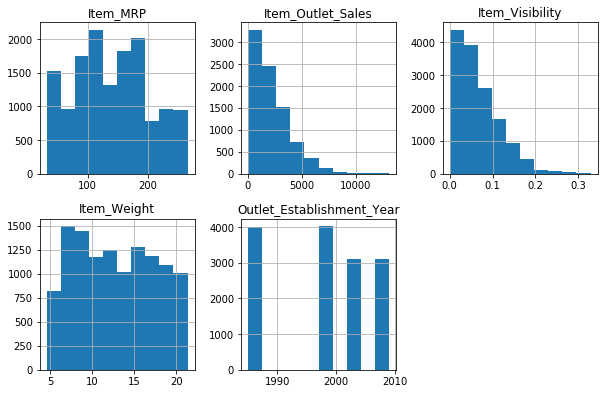

In [7]:
# Visualizing the data
data.hist(figsize=(10,10),layout=(3,3))
plt.show()

This confirms that Item_MRP, Item_Outlet_Sales, Item_Visibility, Item_Weight are numerical variables. By looking at the histogram of Outlet_Establishment_Year, one might think it is of categorical nature but it is not as it varies continuously. 

In [8]:
data.describe(include="all") # Prints the summary statistics of all variables (numerical and categorical)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
count,14204,11765.000000,14204,14204.000000,14204,14204.000000,14204,14204.000000,10188,14204,14204,8523.000000,14204
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN,2
top,FDG47,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN,train
freq,10,NaN,8485,NaN,2013,NaN,1559,NaN,4655,5583,9294,NaN,8523
mean,NaN,12.792854,NaN,0.065953,NaN,141.004977,NaN,1997.830681,NaN,NaN,NaN,2181.288914,NaN
std,NaN,4.652502,NaN,0.051459,NaN,62.086938,NaN,8.371664,NaN,NaN,NaN,1706.499616,NaN
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000,NaN
25%,NaN,8.710000,NaN,0.027036,NaN,94.012000,NaN,1987.000000,NaN,NaN,NaN,834.247400,NaN
50%,NaN,12.600000,NaN,0.054021,NaN,142.247000,NaN,1999.000000,NaN,NaN,NaN,1794.331000,NaN
75%,NaN,16.750000,NaN,0.094037,NaN,185.855600,NaN,2004.000000,NaN,NaN,NaN,3101.296400,NaN



### Skewness

Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined. In a perfectly symmetrical distribution, the mean, the median, and the mode will all have the same value. However, the variables in our data are not symmetrical, resulting in different values of the central tendency.

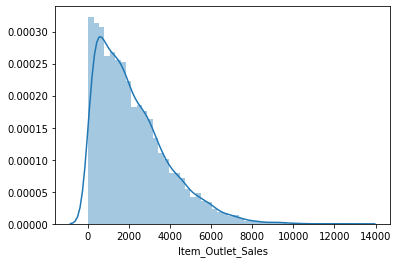

In [9]:
sns.distplot(train_data['Item_Outlet_Sales']);

We can see that target variable has right skewed distribution with a long tail towards high values. We'll need to log transform this variable so that it becomes normally distributed. A normally distributed target variable helps in better modeling the relationship between target and independent variables.

In [10]:
print(f"Skewness of Item Outlet Sales is {train_data['Item_Outlet_Sales'].skew()}")

Skewness of Item Outlet Sales is 1.1775306028542798


Skewness is -0.887753343209305


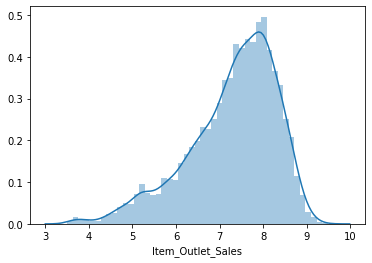

In [11]:
# Applying log transformation to the target variable
target = np.log(train_data['Item_Outlet_Sales'])
print(f"Skewness is {target.skew()}")

# Visualizing target variable after applying log transformation
sns.distplot(target);

The log method did not convert the skewed distribution into normalized distribution so now applying square root transformation.

Skewness is 0.23467599347099255


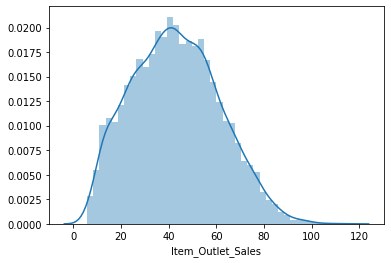

In [12]:
# Applying square root transformation to the target variable
target = np.sqrt(train_data['Item_Outlet_Sales'])
print(f"Skewness is {target.skew()}")

# Visualizing the target variable after applying square root transformation
sns.distplot(target);

Now, here square root method has helped to change from skewed distribution into normal distribution.

## Data Exploration
Data Exploration is a technique of analysing datasets by summarizing the characterstics and visulizations to understand the dataset in a better form. Steps that are involved in building a predictive model are Univariate and Bivariate Analysis, Missing values Treatment, Variable Transformation and Variable creation.

### Univariate Analysis
Univariate Analysis explores the variables one by one. The methods to perform univariate analysis are different for continuous and categorical variables.The metrics used for univariate analysis in case of continuous variables is central tendency like mean, standard deviation etc and histograms are used for visualisation purposes. In case of categorical variables, frequency distribution table which contains Count and Count% is used and bar chart are used for visualisation purpose.

[Text(0, 0.5, '% of distribution'), Text(0.5, 1.0, 'Ananlysis of Item_weight')]

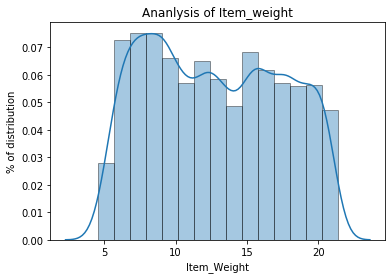

In [13]:
# Plotting Histogram of Item_Weight 
ax = sns.distplot(data['Item_Weight'].dropna(), hist=True, bins=15, hist_kws={'edgecolor':'black'});
ax.set(ylabel="% of distribution", title="Ananlysis of Item_weight")

In [14]:
# Metrics for analysis of Item_Weight
data['Item_Weight'].describe()

count    11765.000000
mean        12.792854
std          4.652502
min          4.555000
25%          8.710000
50%         12.600000
75%         16.750000
max         21.350000
Name: Item_Weight, dtype: float64

#### Observations

1. 65% of products have weight less than 10
2. 60% of products have weight less than 20
3. There are no outliers

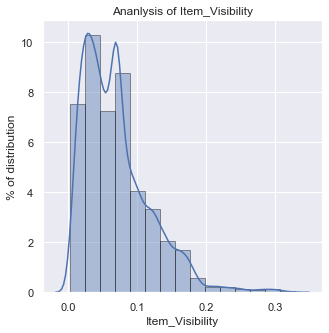

In [94]:
# Plotting Histogram of Item_Visibility
ax = sns.distplot(data['Item_Visibility'].dropna(), hist=True, bins=15, hist_kws={'edgecolor':'black'});
ax.set(ylabel="% of distribution", title="Ananlysis of Item_Visibility");

In [16]:
# Metrics for analysis of Item_Visibility
data['Item_Visibility'].describe()

count    14204.000000
mean         0.065953
std          0.051459
min          0.000000
25%          0.027036
50%          0.054021
75%          0.094037
max          0.328391
Name: Item_Visibility, dtype: float64

#### Observations
1. 10% of the products have Item_Visibility 0.025
2. Less products are present of higher visibility. This is may be due to the fact of higher sales of the particular product.

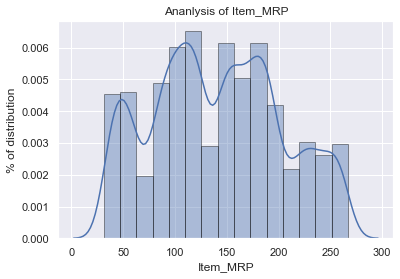

In [29]:
# Plotting Histogram of Item_MRP
ax = sns.distplot(data['Item_MRP'].dropna(), hist=True, bins=15, hist_kws={'edgecolor':'black'});
ax.set(ylabel="% of distribution", title="Ananlysis of Item_MRP");
#plt.show()

In [30]:
# Metrics for analysis of Item_MRP
data['Item_MRP'].describe()

count    14204.000000
mean       141.004977
std         62.086938
min         31.290000
25%         94.012000
50%        142.247000
75%        185.855600
max        266.888400
Name: Item_MRP, dtype: float64

#### Observations
1. Most of MRP lies in range 100 and 180.
2. Food items having MRP greater than 200 are less.

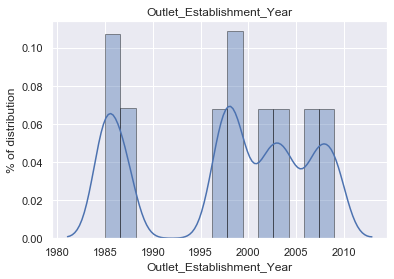

In [32]:
# Plotting Histogram of Outlet_Establishment_Year
ax = sns.distplot(data['Outlet_Establishment_Year'].dropna(), hist=True, bins=15, hist_kws={'edgecolor':'black'});
ax.set(ylabel="% of distribution", title="Outlet_Establishment_Year");

In [33]:
# Metrics for analysis of Outlet_Establishment_Year
data['Outlet_Establishment_Year'].describe()

count    14204.000000
mean      1997.830681
std          8.371664
min       1985.000000
25%       1987.000000
50%       1999.000000
75%       2004.000000
max       2009.000000
Name: Outlet_Establishment_Year, dtype: float64

#### Observations
1. There are no sales from year 1990 to 1995.
2. 65% of products are sold in year 1985.
3. 70% of products are sold in year 1997.

### Correlation Matrix

In [34]:
# Separate numerical and categorical data
numerical_data = train_data.select_dtypes(include=[np.number])
categorical_data = train_data.select_dtypes(exclude=[np.number])
print(f"There are {numerical_data.shape[1]} columns having numerical data- {', '.join(numerical_data.columns)}")
print(f"There are {categorical_data.shape[1]} columns having categorical data - {', '.join(categorical_data.columns)}")

There are 5 columns having numerical data- Item_Weight, Item_Visibility, Item_MRP, Outlet_Establishment_Year, Item_Outlet_Sales
There are 8 columns having categorical data - Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type, source


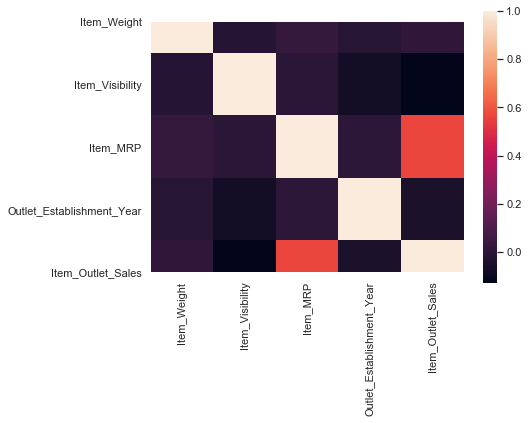

In [35]:
corr = numerical_data.corr()
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr, square=True);

#### Conclusions


1. Item_Visibility has the least correlation with Item_Outlet_Sales according to the Correlation Matrix which means that if product is less visible then sales will be higher. But this may not be the case.
2. Item_MRP has highest correlation with Item_Outlet_Sales which means if the price of the product increases then sale of that product also increases.

A numeric correlation score will help us understand the correlation matrix in a better form. Correlation score of all the variables with Item_outlet_Sales is shown below 

In [36]:
print(corr["Item_Outlet_Sales"].sort_values(ascending=False))

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64


Item_MRP feature is 56% correlated with Item_Outlet_Sales (target variable)

#### Univariate Analysis on Categorical Variables

In [37]:
print(data['Item_Fat_Content'].value_counts()) # Category along with their counts will be displayed

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


The category Low Fat has been miscoded as LF and low fat category. Also, category Regular has been miscoded as reg. Now we will be replacing the category LF and low fat with that of Low Fat category and category reg with Regular. 

In [38]:
# Replacing required categories
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'})
print(data['Item_Fat_Content'].value_counts())

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


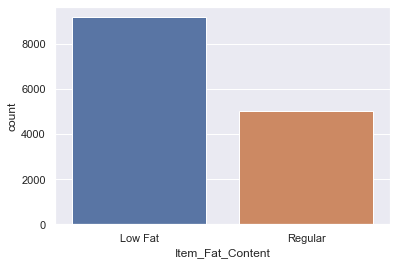

In [39]:
# Plotting the category Item_Fat_Content
sns.set(style="darkgrid")
sns.countplot(data['Item_Fat_Content']);

In [40]:
count = data['Item_Fat_Content'].value_counts().rename('Count')
count_percent = ((data['Item_Fat_Content'].value_counts()/data['Item_Fat_Content'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

         Count     Count%
Low Fat   9185  64.664883
Regular   5019  35.335117


#### Analysis on Item_type 

In [41]:
# Making a frequency table
count = data['Item_Type'].value_counts().rename('Count')
count_percent = ((data['Item_Type'].value_counts()/data['Item_Fat_Content'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

                       Count     Count%
Fruits and Vegetables   2013  14.172064
Snack Foods             1989  14.003098
Household               1548  10.898338
Frozen Foods            1426  10.039426
Dairy                   1136   7.997747
Baking Goods            1086   7.645734
Canned                  1084   7.631653
Health and Hygiene       858   6.040552
Meat                     736   5.181639
Soft Drinks              726   5.111236
Breads                   416   2.928752
Hard Drinks              362   2.548578
Others                   280   1.971276
Starchy Foods            269   1.893833
Breakfast                186   1.309490
Seafood                   89   0.626584


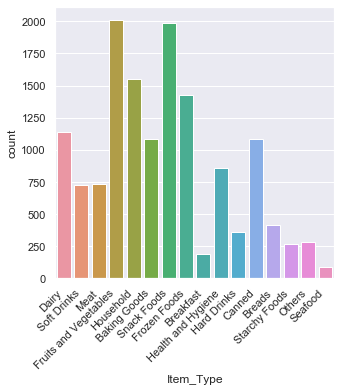

In [42]:
# Plotting the category Item_Type
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(data['Item_Type'])
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Observations
1. Most of foods are from Fruits and Vegetables, Snack Foods and Baking Goods category
2. Food from the Starchy Food, Breakfast and Seafood are less.

#### Analysis on Outlet_Identifier

In [43]:
# Making a frequency table
count = data['Outlet_Identifier'].value_counts().rename('Count')
count_percent = ((data['Outlet_Identifier'].value_counts()/data['Outlet_Identifier'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

        Count     Count%
OUT027   1559  10.975781
OUT013   1553  10.933540
OUT049   1550  10.912419
OUT046   1550  10.912419
OUT035   1550  10.912419
OUT045   1548  10.898338
OUT018   1546  10.884258
OUT017   1543  10.863137
OUT010    925   6.512250
OUT019    880   6.195438


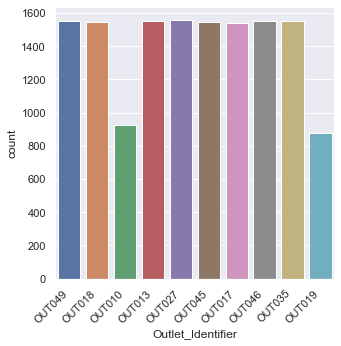

In [44]:
# Plotting the category Outlet_Identifier
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(data['Outlet_Identifier'])
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Observations
1. Number of products are same in outlets having numbers OUT49, OUT35, OUT46.
2. Highest number of products are in OUT027 and least in OUTO10

#### Analysis on Outlet_Size

In [45]:
# Making a frequency table
count = data['Outlet_Size'].value_counts().rename('Count')
count_percent = ((data['Outlet_Size'].value_counts()/data['Outlet_Size'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

        Count     Count%
Medium   4655  32.772458
Small    3980  28.020276
High     1553  10.933540


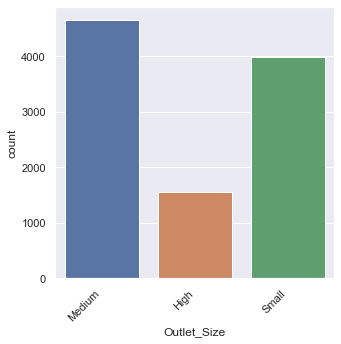

In [46]:
# Plotting the category Outlet_Size
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(data['Outlet_Size'])
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Observations
1. Most of the outlets have medium size followed by small size.
2. Only 10% of outlets are in high category with respect to size.

#### Analysis on Outlet_Location_Type

In [47]:
# Making a frequency table
count = data['Outlet_Location_Type'].value_counts().rename('Count')
count_percent = ((data['Outlet_Location_Type'].value_counts()/data['Outlet_Location_Type'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

        Count     Count%
Tier 3   5583  39.305829
Tier 2   4641  32.673895
Tier 1   3980  28.020276


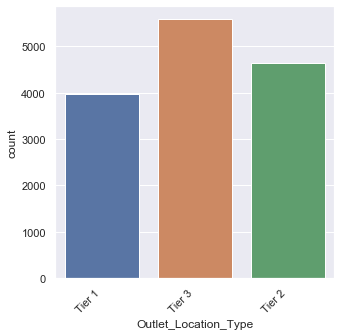

In [48]:
# Plotting the category Outlet_Location_Type
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(data['Outlet_Location_Type'])
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Observations 
1. 39% of outlets are in Tier 3
2. Tier 1 has least number of outlets 

#### Analysis on Outlet_Type

In [49]:
# Making a frequency table
count = data['Outlet_Type'].value_counts().rename('Count')
count_percent = ((data['Outlet_Type'].value_counts()/data['Outlet_Type'].size) * 100).rename('Count%')
freq_table = pd.concat([count,count_percent],axis=1)
print(freq_table)

                   Count     Count%
Supermarket Type1   9294  65.432273
Grocery Store       1805  12.707688
Supermarket Type3   1559  10.975781
Supermarket Type2   1546  10.884258


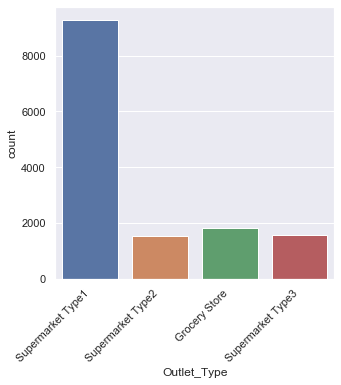

In [50]:
# Plotting the category Outlet_Type
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.countplot(data['Outlet_Type'])
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Observations
1. 65% of the outlets are of type Supermarket Type 1
2. 10% of the outlets are of type Supermarket Type 1 and Supermarket Type 3 

### Bivariate Analysis
Bi-variate Analysis finds out the relationship between two variables. These variables can be of any combination like categorical and categorical, categorical and continuous and continuous and continuous. Different methods are used to tackle these combinations during analysis process.

#### Applying correlation between numerical features and target variable.
The analysis between numerical features and target variables is understood using scatter plots. The target variable i.e Item_Outlet_Sales is a continuous variable so below relations between continuous and continuous variables are being analysed here. 

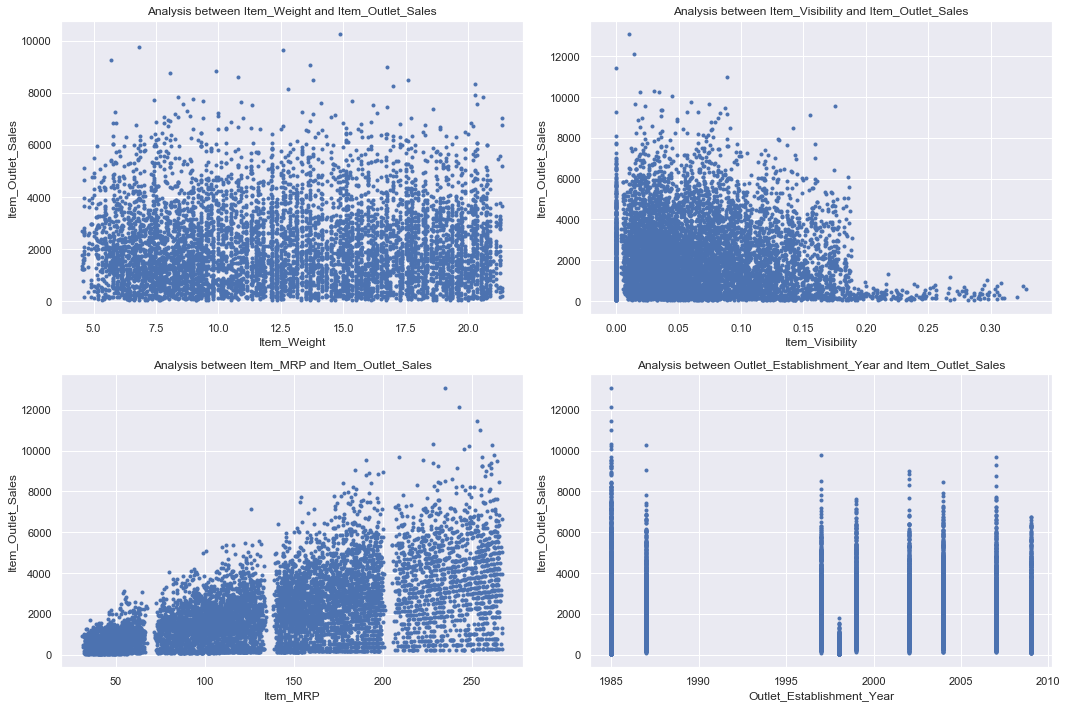

In [51]:
fig, axes = plt.subplots(2,2,figsize=(15,10))


axes[0,0].scatter(data['Item_Weight'], data['Item_Outlet_Sales'], marker='.')
axes[0,0].set(title="Analysis between Item_Weight and Item_Outlet_Sales", xlabel="Item_Weight", ylabel="Item_Outlet_Sales")


axes[0,1].scatter(data['Item_Visibility'], data['Item_Outlet_Sales'], marker='.')
axes[0,1].set(title="Analysis between Item_Visibility and Item_Outlet_Sales", xlabel="Item_Visibility", ylabel="Item_Outlet_Sales")


axes[1,0].scatter(data['Item_MRP'], data['Item_Outlet_Sales'], marker='.')
axes[1,0].set(title="Analysis between Item_MRP and Item_Outlet_Sales", xlabel="Item_MRP", ylabel="Item_Outlet_Sales")


axes[1,1].scatter(data['Outlet_Establishment_Year'], data['Item_Outlet_Sales'], marker='.')
axes[1,1].set(title="Analysis between Outlet_Establishment_Year and Item_Outlet_Sales", 
              xlabel="Outlet_Establishment_Year",
              ylabel="Item_Outlet_Sales")

fig.tight_layout()
plt.show()

#### Observations

1. There is no pattern between Item_Weight and Outlet_Sales
2. The second plot indictates that if the product is more visible in the store less will be the sales. This plot also shows      that there are large number of products with zero visibility.
3. In third plot of Item_MRP vs Item_Outlet_Sales, there are four segments of prices that can be used in feature engineering to    create a new variable.
4. In fourth plot of Outlet_Establishment_Year vs Item_Outlet_Sales, we can see that Outlet_Establishment_Year should be          considered as categorical variable instead of continuous variable which will be corrected later.

#### Analysing Relationships between Categorical Variables and Target Variable

Relationships between numerical variables and categorical variables are being analysed using the box-and-whisker plot

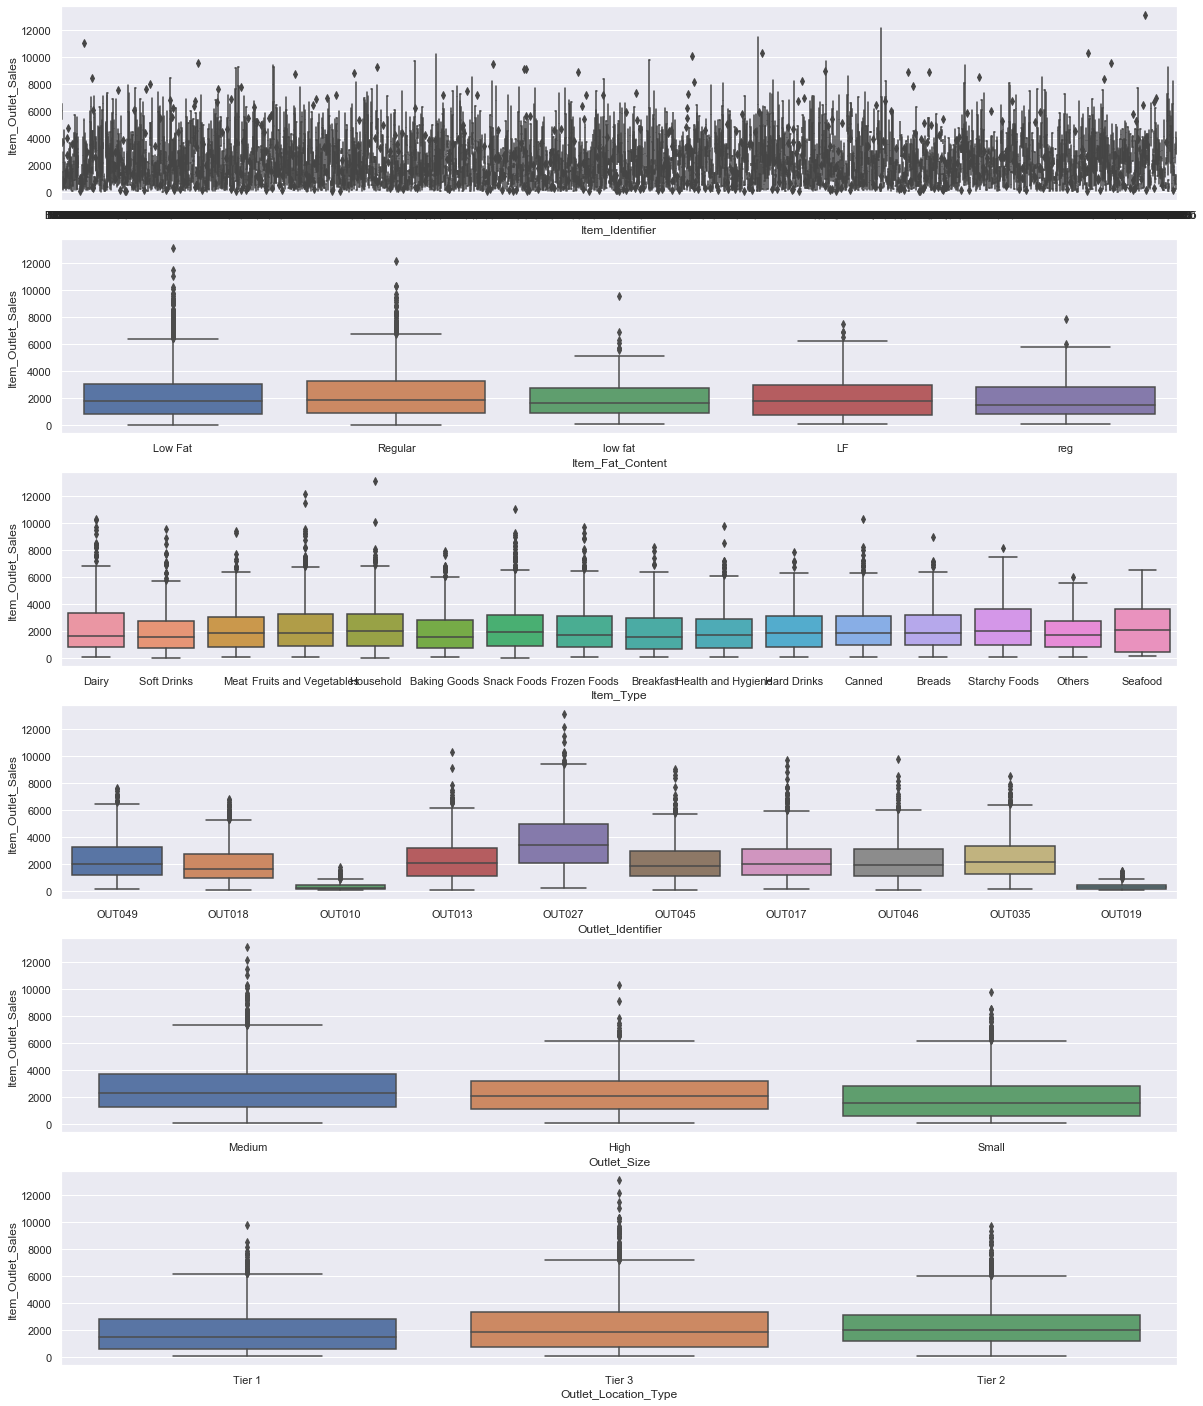

In [52]:
fig, axes = plt.subplots(6,1,figsize=(20,25))
for category,ax in zip(categorical_data.columns,axes.flatten()):
    if category != 'source':
        sns.boxplot(x=category, y=data["Item_Outlet_Sales"], data=categorical_data, ax=ax);

#### Observations
1. There are no boxplots between Item_Outlet_Sales and Item_Identifier as Item_Identifier is a number.
2. Categories are to be changed in second plot which will be done later.
3. Starchy food and seafood are having more sales.
4. Sales are mostly in OUT027 and least in OUT019
5. Most of the sales are in outlets having medium size
6. Tier 3 is having highest number of sales 

### Data Cleaning
Data cleaning involves imputing the missing values of different columns and treating outliers.The first step is to know the number of missing values of each column and then impute those values using mean, median and mode. Outliers has not been treated because tree algorithms like random forest, decision tree, xgboost are impervious to outliers  

#### Dealing with Missing Values

In [53]:
data.isnull().sum() # Count of missing values of each column in dataset

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

We can clearly see that there are three columns i.e Item_Weight, Outlet_Size and Item_Outlet_Sales with missing values.

In [54]:
train_data.isnull().sum() # Count of missing values of each column in training dataset

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

The missing values of Item_Outlet_Sales belong to the test dataset so we will be imputing the missing values of Item_Weight and Outlet_Size of the dataset.

In [55]:
# Imputing the values of Item_Weight column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(data[['Item_Weight']])
data[['Item_Weight']] = imputer.transform(data[['Item_Weight']])

In [56]:
# Imputing the values of Outlet_Size column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(data[['Outlet_Size']])
data[['Outlet_Size']] = imputer.transform(data[['Outlet_Size']])

In [57]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

### Feature Engineering
Feature Engineering is an art of extracting information from existing data. The two techniques that are performed in feature engineering are feature creation and feature transformation. A new feature is to be created based on previous analysis of data. Feature transformation is about changing the feature like one hot encoding of categorical variables. 

#### Modify Item_Visibility

In the bivariate analysis of Item_Visibility vs Item_Outlet_Sales, there were a lot of zeroes in the scatterplot representing large number of products with zero visibility which is impossible so we will be imputing those missing values with mean.

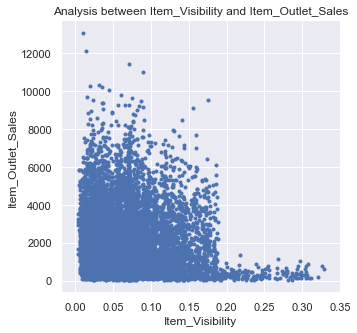

In [58]:
# Imputing zeroes with mean values
imputer = SimpleImputer(missing_values=0, strategy='mean')
imputer.fit(data[['Item_Visibility']])
data[['Item_Visibility']] = imputer.transform(data[['Item_Visibility']])

# Displaying scatterplot with mean values instead of zeroes
fig, ax = plt.subplots(figsize=(5,5));
plt.scatter(x=data["Item_Visibility"], y=data["Item_Outlet_Sales"], marker='.')
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Analysis between Item_Visibility and Item_Outlet_Sales")
plt.show()

In [59]:
data.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].mean()

Outlet_Establishment_Year
1985    2483.677474
1987    2298.995256
1997    2277.844267
1998     339.351662
1999    2348.354635
2002    2192.384798
2004    2438.841866
2007    2340.675263
2009    1995.498739
Name: Item_Outlet_Sales, dtype: float64

#### Determine the years of operation of store 

In [60]:
# Creating a new feature from Outlet_Establishment_Year
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

#### Create broad category on Item_Type 

There are almost 16 categories of Item_Type which might not prove to be very useful in analysis. First two letters of Item_Identifier tells that categories of Item_Type can be grouped together in broader categories like FD stands for Food, DR stands for Drinks and NC stands for Non Consumable. 

In [61]:
# Get the first two characters of Item_Identifier
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])

# Creating broader categories
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non Consumable',
                                                             'DR':'Drinks'})
# Dropping the column Item_Type
data['Item_Type_Combined'].value_counts()

Food              10201
Non Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

#### Create category in Item_Fat_Content

There is need of creating a category Non Edibile for the Non Consumables category of Item_Type as Low and High Fat category would not be suitable.

In [62]:
data.loc[data['Item_Type_Combined']=='Non Consumable',"Item_Fat_Content"] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

#### Encoding of Categorical Data

In [63]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Type_Combined
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,14,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,4,Drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,14,Food
3,FDX07,19.20,Regular,0.070303,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train,15,Food
4,NCD19,8.93,Non-Edible,0.070303,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,26,Non Consumable


In [64]:
# Changing the categorical columns with numbers
categorical_cols = ['Item_Fat_Content', 'Item_Type_Combined', 'Outlet_Size', 
                    'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Years']
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])
data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Type_Combined
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,train,4,1
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,train,0,0
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,train,4,1
3,FDX07,19.20,2,0.070303,Fruits and Vegetables,182.0950,OUT010,1998,1,2,0,732.3800,train,5,1
4,NCD19,8.93,1,0.070303,Household,53.8614,OUT013,1987,0,2,1,994.7052,train,7,2


In [65]:
# One Hot Encoding of columns
data = pd.get_dummies(data, columns=categorical_cols) 
data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,source,Item_Fat_Content_0,...,Outlet_Type_3,Outlet_Years_0,Outlet_Years_1,Outlet_Years_2,Outlet_Years_3,Outlet_Years_4,Outlet_Years_5,Outlet_Years_6,Outlet_Years_7,Outlet_Years_8
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,train,1,...,0,0,0,0,0,1,0,0,0,0
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,train,0,...,0,1,0,0,0,0,0,0,0,0
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,2097.2700,train,1,...,0,0,0,0,0,1,0,0,0,0
3,FDX07,19.20,0.070303,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,train,0,...,0,0,0,0,0,0,1,0,0,0
4,NCD19,8.93,0.070303,Household,53.8614,OUT013,1987,994.7052,train,0,...,0,0,0,0,0,0,0,0,1,0


#### Exporting Data

In [66]:
# Dropping columns which have been already converted into another features
data.drop(['Item_Type','Outlet_Establishment_Year'], axis=1, inplace=True)

# Dividing the dataset into train and test datasets
train = data.loc[data['source']=="train"].copy()
test = data.loc[data['source']=="test"].copy()

# Dropping the columns
test.drop(['Item_Outlet_Sales','source'], axis=1, inplace=True)
train.drop('source', axis=1, inplace=True)

# Converting the datasets to .csv files
train.to_csv("train_modified.csv", index=False)
test.to_csv("test_modified.csv", index=False)

In [67]:
# Reading the modified files of train and test dataset
train_df = pd.read_csv("train_modified.csv")
test_df = pd.read_csv("test_modified.csv")

In [68]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Type_Combined_0,...,Outlet_Type_3,Outlet_Years_0,Outlet_Years_1,Outlet_Years_2,Outlet_Years_3,Outlet_Years_4,Outlet_Years_5,Outlet_Years_6,Outlet_Years_7,Outlet_Years_8
0,FDA15,9.30,0.016047,249.8092,OUT049,3735.1380,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,443.4228,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
2,FDN15,17.50,0.016760,141.6180,OUT049,2097.2700,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,FDX07,19.20,0.070303,182.0950,OUT010,732.3800,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,NCD19,8.93,0.070303,53.8614,OUT013,994.7052,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [69]:
train_df.dtypes

Item_Identifier            object
Item_Weight               float64
Item_Visibility           float64
Item_MRP                  float64
Outlet_Identifier          object
Item_Outlet_Sales         float64
Item_Fat_Content_0          int64
Item_Fat_Content_1          int64
Item_Fat_Content_2          int64
Item_Type_Combined_0        int64
Item_Type_Combined_1        int64
Item_Type_Combined_2        int64
Outlet_Size_0               int64
Outlet_Size_1               int64
Outlet_Size_2               int64
Outlet_Location_Type_0      int64
Outlet_Location_Type_1      int64
Outlet_Location_Type_2      int64
Outlet_Type_0               int64
Outlet_Type_1               int64
Outlet_Type_2               int64
Outlet_Type_3               int64
Outlet_Years_0              int64
Outlet_Years_1              int64
Outlet_Years_2              int64
Outlet_Years_3              int64
Outlet_Years_4              int64
Outlet_Years_5              int64
Outlet_Years_6              int64
Outlet_Years_7

In [89]:
# Linear Regression Model
features = [col for col in train_df.columns if col not in ('Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier')]
target = 'Item_Outlet_Sales'
X_train = train_df[features]
y_train = train_df['Item_Outlet_Sales']
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
# print(y_pred)
# print(f"Coefficients are {regressor.coef_}")
print(f"R^2 Score is {regressor.score(X_train, y_train)}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

[4056.86913111  574.12179383 2368.84143149 ... 1509.09970445 1414.5191553
 1220.98717537]
Coefficients are [-5.88499529e-01 -2.29401262e+02  1.55561496e+01 -1.40795482e+01
 -1.34424539e+01  2.75220021e+01 -1.56641647e+00  1.50088703e+01
 -1.34424539e+01 -1.07192548e+02  2.19503366e+02 -1.12310819e+02
 -2.54216736e+02 -1.72156148e+01  2.71432351e+02 -1.37625827e+03
  4.25976326e+02 -1.57770708e+02  1.10805265e+03 -1.57770708e+02
 -7.27042319e+01  2.99872426e+02 -2.44383809e+02  1.57966509e+02
 -5.71657047e+02  3.92417980e+02 -1.07192548e+02  3.03451429e+02]
R^2 Score is 0.563479254447071
MSE: 1271060.7831030414
RMSE: 1127.4133151169722


In [71]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Item_Type_Combined_0,Item_Type_Combined_1,...,Outlet_Type_3,Outlet_Years_0,Outlet_Years_1,Outlet_Years_2,Outlet_Years_3,Outlet_Years_4,Outlet_Years_5,Outlet_Years_6,Outlet_Years_7,Outlet_Years_8
0,FDW58,20.750000,0.007565,107.8622,OUT049,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,FDW14,8.300000,0.038428,87.3198,OUT017,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,NCN55,14.600000,0.099575,241.7538,OUT010,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,FDQ58,7.315000,0.015388,155.0340,OUT017,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,FDY38,12.792854,0.118599,234.2300,OUT027,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1


In [90]:
# Ridge Regression Model
ridge_cv = RidgeCV(alphas=[0.001,0.1,1.0])
ridge_cv.fit(X_train,y_train)
y_pred = ridge_cv.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f"Value of alpha is {ridge_cv.alpha_}")
print(f"R^2 Score : {ridge_cv.score(X_train,y_train)}")
print(f"RMSE: {rmse}")

Value of alpha is 1.0
R^2 Score : 0.5634790577522832
RMSE: 1127.413569121278


In [91]:
# Lasso Regression Model
lasso = Lasso()
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f"R^2 Score : {lasso.score(X_train,y_train)}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

R^2 Score : 0.5634107280016212
MSE: 1271260.3183560714
RMSE: 1127.5018041475905


In [92]:
# Decision Tree Regression Model
decision_tree = DecisionTreeRegressor(max_depth=5)  
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f"R^2 Score : {decision_tree.score(X_train,y_train)}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R^2 Score : 0.60360465585572
MSE: 1154223.6690451552
RMSE: 1074.3480204501498


In [93]:
# XGBOOST Model
xg_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.3)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f"R^2 Score : {decision_tree.score(X_train,y_train)}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse}")

R^2 Score : 0.60360465585572
MSE : 15831.22884300096
RMSE: 125.82221124666725


In [87]:
# XGBOOST Model using cross validation
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=100)
rmse = cv_results['train-rmse-mean'][29]
print(f"RMSE: {rmse}")

RMSE: 1032.2717773999998


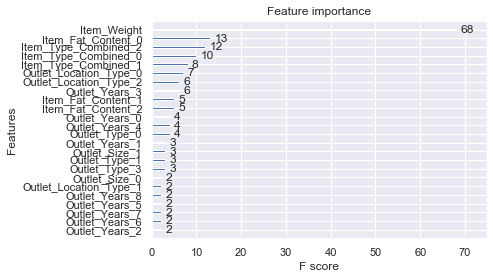

In [88]:
# Plotting features importance
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()